# New York City Taxi Fare Prediction

The task is to predict the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.  While I can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used. The challenge is to do better than this using Machine Learning techniques!

All datasets and the task itself were taken from the Kaggle playground competition, I do not own any of them.

## Taxi fare prediction analysis - cleaning up the training data


First we need to look at the data:

In [2]:
# load some default Python modules that will be used for all the sections of the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline
plt.style.use('seaborn-whitegrid')



In [3]:
# read training data with limiting to the rows, as the file is big

tax_train = pd.read_csv("train.csv", nrows = 100_000, parse_dates=["pickup_datetime"])

#and checking what columns the dataframe has
tax_train.columns.to_list()

['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [4]:
# i can also check how the table would look like and get the shape of the dataframe
print(tax_train.shape)
tax_train.head()

(100000, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


I check the type of the data, I will need it later to pick up features for training.

In [5]:
# check datatypes
tax_train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

I check how the data looks like:

In [6]:
tax_train.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


I double check if there are any missing values (looks like there is none).

In [7]:
# get the number of missing data points per column
missing_values_count = tax_train.isnull().sum()

# look at the # of missing points
print(missing_values_count)

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


From the data description it looks that some `fare_amount` values are negative. As it cannot be so, I drop the negative values.

In [9]:
# I filter out all negative values from the dataframe
tax_train = tax_train[tax_train.fare_amount > 0]

In [10]:
# checking how the data looks like now
tax_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,99988.000000,99988.000000,99988.000000,99988.000000,99988.000000,99988.000000
mean,11.356728,-72.494509,39.914382,-72.491533,39.919360,1.673781
std,9.714644,10.694564,6.226052,10.469494,6.212511,1.300098
min,0.010000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966986,40.767258,-73.963438,40.768164,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


Ok, now no negative values in `fare_amount` and no NaN. All good.

Now I check what is going on with longtitude and latitude, that should be withing the following ranges:

* Latitudes range from -90 to 90.
* Longitudes range from -180 to 180.

In [11]:
# checking data on latitude
tax_train['pickup_latitude'].describe()

count    99988.000000
mean        39.914382
std          6.226052
min        -74.007670
25%         40.734996
50%         40.752765
75%         40.767258
max        401.083332
Name: pickup_latitude, dtype: float64

In [12]:
# checking data on longtitude
tax_train['pickup_longitude'].describe()

count    99988.000000
mean       -72.494509
std         10.694564
min       -736.550000
25%        -73.992041
50%        -73.981789
75%        -73.966986
max         40.787575
Name: pickup_longitude, dtype: float64

In [13]:
# checking data on latitude
tax_train['dropoff_latitude'].describe()

count    99988.000000
mean        39.919360
std          6.212511
min        -74.006377
25%         40.734182
50%         40.753243
75%         40.768164
max        404.616667
Name: dropoff_latitude, dtype: float64

In [14]:
# checking data on longtitude
tax_train['dropoff_longitude'].describe()

count    99988.000000
mean       -72.491533
std         10.469494
min        -84.654241
25%        -73.991215
50%        -73.980000
75%        -73.963438
max         40.851027
Name: dropoff_longitude, dtype: float64

Looks like here is also all fine for my dataset.

## Taxi fare prediction analysis - cleaning up the test data

Then I take a look into the test set to see how the columns look like there

In [15]:
# Read test data

tax_test = pd.read_csv("test.csv", nrows = 2_000)

#and checking what columns the data table has
tax_test.columns.to_list()

['key',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [16]:
# Checking how the test data looks like
tax_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2000.000000,2000.000000,2000.000000,2000.000000,1.0
mean,40.692830,-73.916841,40.693120,1.019872,1.0
std,2.565463,2.565859,2.565693,0.888699,NaN
min,-73.973320,-74.263242,-73.981430,1.000000,1.0
25%,40.735097,-73.991009,40.734700,1.000000,1.0
50%,40.752976,-73.980150,40.753934,1.000000,1.0
75%,40.767182,-73.963539,40.768612,1.000000,1.0
max,41.069660,40.763805,41.051657,40.743835,1.0


As I can see there is no `fare_amount` column, as I need to predict that column. 
There are some NaN values in the `passenger_count`:

In [17]:
# get the number of missing data points per column
missing_values_count_test = tax_test.isnull().sum()

# look at the # of missing points
print(missing_values_count_test)

key                     0
pickup_datetime         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
passenger_count      1999
dtype: int64


And in percentage:

In [18]:
# how many total missing values do we have
total_cells = np.product(tax_test.shape)
total_missing = missing_values_count_test.sum()
 
# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

14.278571428571428


14.3% looks a bit too much for me to just remove all rows with missing values. So I will refill the NaN cells with mean values:

In [20]:
# Fill NaN with mean value
tax_test = tax_test.fillna(tax_test.mean())

In [21]:
# check how my data looks like now
tax_test.describe()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.0
mean,40.692830,-73.916841,40.693120,1.019872,1.0
std,2.565463,2.565859,2.565693,0.888699,0.0
min,-73.973320,-74.263242,-73.981430,1.000000,1.0
25%,40.735097,-73.991009,40.734700,1.000000,1.0
50%,40.752976,-73.980150,40.753934,1.000000,1.0
75%,40.767182,-73.963539,40.768612,1.000000,1.0
max,41.069660,40.763805,41.051657,40.743835,1.0


In [22]:
# get the number of missing data points per column
missing_values_count_test = tax_test.isnull().sum()

# look at the # of missing points
print(missing_values_count_test)

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


Checking longtitude and latitude parameters:

* Latitudes range from -90 to 90.
* Longitudes range from -180 to 180.

In [23]:
# checking data on latitude
tax_test['pickup_latitude'].describe()

count    2000.000000
mean      -73.916841
std         2.565859
min       -74.263242
25%       -73.991009
50%       -73.980150
75%       -73.963539
max        40.763805
Name: pickup_latitude, dtype: float64

In [24]:
# checking data on latitude
tax_test['pickup_longitude'].describe()

count    2000.000000
mean       40.692830
std         2.565463
min       -73.973320
25%        40.735097
50%        40.752976
75%        40.767182
max        41.069660
Name: pickup_longitude, dtype: float64

In [25]:
# checking data on latitude
tax_test['dropoff_latitude'].describe()

count    2000.000000
mean        1.019872
std         0.888699
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        40.743835
Name: dropoff_latitude, dtype: float64

In [26]:
# checking data on latitude
tax_test['dropoff_longitude'].describe()

count    2000.000000
mean       40.693120
std         2.565693
min       -73.981430
25%        40.734700
50%        40.753934
75%        40.768612
max        41.051657
Name: dropoff_longitude, dtype: float64

Looks good, so now I can move on to analysis.

## Determine the problem and choose the model.

After looking at the data, I need to determine a problem, to understand what kind of Machine Learning model to use.

I start with creating a histogramm of the data:

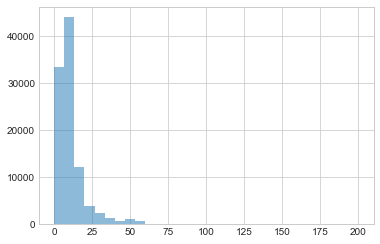

In [27]:
# Plot a histogram
tax_train.fare_amount.hist(bins=30, alpha=0.5)
plt.show()

From histogram I can see, that the `fare_amount` is a contionous variable, therefore I am dealing with the regression problem.

In [29]:
# Creating a LinearRegression object
lr = LinearRegression() 


In [30]:
# Fit the model on the train data

lr.fit(X=tax_train[['pickup_longitude',  'pickup_latitude',  'dropoff_longitude',  'dropoff_latitude',  'passenger_count']],
        y=tax_train['fare_amount'])

LinearRegression()

Then I take the fitted `lr` object and predict the fare amount:

In [32]:
# Select features
features = ['pickup_longitude',  'pickup_latitude',  'dropoff_longitude',  'dropoff_latitude',  'passenger_count']

#make prediction on the test data and store results to the `fare_amount` column
tax_test['fare_amount'] = lr.predict(tax_test[features])

In [33]:
# checking if all worked fine 
tax_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1.0,11.265628
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24-73.986862182617188,40.719383,-73.998886,40.739201,1.000000,1.0,14.248636
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44-73.982524,40.751260,-73.979654,40.746139,1.000000,1.0,14.248451
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12-73.98116,40.767807,-73.990448,40.751635,1.000000,1.0,14.248941
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12-73.966046,40.789775,-73.988565,40.744427,1.000000,1.0,14.249203
